In [3]:
import math
import random
import numpy as np

class Node:
    def __init__(self, node_id, activation, init_zero=False):
        self.id = node_id
        self.input_links = []
        self.bias = 0.1
        self.outputs = []
        self.total_input = 0
        self.output = 0
        self.output_der = 0
        self.input_der = 0
        self.acc_input_der = 0
        self.num_accumulated_ders = 0
        self.activation = activation

        if init_zero:
            self.bias = 0

    def update_output(self):
        self.total_input = self.bias + sum(link.weight * link.source.output for link in self.input_links)
        self.output = self.activation.output(self.total_input)
        return self.output

class ErrorFunction:
    def __init__(self, error_func, der_func):
        self.error = error_func
        self.der = der_func

class ActivationFunction:
    def __init__(self, output_func, der_func):
        self.output = output_func
        self.der = der_func

class RegularizationFunction:
    def __init__(self, output_func, der_func):
        self.output = output_func
        self.der = der_func

class Link:
    def __init__(self, source, dest, regularization, init_zero=False):
        self.id = source.id + "-" + dest.id
        self.source = source
        self.dest = dest
        self.weight = random.random() - 0.5
        self.is_dead = False
        self.error_der = 0
        self.acc_error_der = 0
        self.num_accumulated_ders = 0
        self.regularization = regularization

        if init_zero:
            self.weight = 0


class Activations:
    TANH = ActivationFunction(np.tanh, lambda x: 1 - np.tanh(x) ** 2)
    RELU = ActivationFunction(lambda x: max(0, x), lambda x: 0 if x <= 0 else 1)
    SIGMOID = ActivationFunction(lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x))
    LINEAR = ActivationFunction(lambda x: x, lambda x: 1)

class RegularizationFunctions:
    L1 = RegularizationFunction(lambda w: abs(w), lambda w: -1 if w < 0 else (1 if w > 0 else 0))
    L2 = RegularizationFunction(lambda w: 0.5 * w * w, lambda w: w)

class Errors:
    SQUARE = ErrorFunction(lambda output, target: 0.5 * (output - target) ** 2, lambda output, target: output - target)

def build_network(network_shape, activation, output_activation, regularization, input_ids, init_zero=False):
    num_layers = len(network_shape)
    id_counter = 1
    network = []

    for layer_idx in range(num_layers):
        is_output_layer = layer_idx == num_layers - 1
        is_input_layer = layer_idx == 0
        current_layer = []
        network.append(current_layer)
        num_nodes = network_shape[layer_idx]

        for i in range(num_nodes):
            node_id = input_ids[i] if is_input_layer else str(id_counter)
            id_counter += 1
            node = Node(node_id, output_activation if is_output_layer else activation, init_zero)
            current_layer.append(node)

            if layer_idx >= 1:
                for j in range(len(network[layer_idx - 1])):
                    prev_node = network[layer_idx - 1][j]
                    link = Link(prev_node, node, regularization, init_zero)
                    prev_node.outputs.append(link)
                    node.input_links.append(link)

    return network

def forward_prop(network, inputs):
    input_layer = network[0]

    if len(inputs) != len(input_layer):
        raise ValueError("The number of inputs must match the number of nodes in the input layer")

    for i in range(len(input_layer)):
        node = input_layer[i]
        node.output = inputs[i]

    for layer_idx in range(1, len(network)):
        current_layer = network[layer_idx]

        for i in range(len(current_layer)):
            node = current_layer[i]
            node.update_output()

    return network[-1][0].output

def back_prop(network, target, error_func):
    output_node = network[-1][0]
    output_node.output_der = error_func.der(output_node.output, target)

    for layer_idx in range(len(network) - 1, 0, -1):
        current_layer = network[layer_idx]

        for i in range(len(current_layer)):
            node = current_layer[i]
            node.input_der = node.output_der * node.activation.der(node.total_input)
            node.acc_input_der += node.input_der
            node.num_accumulated_ders += 1

        for i in range(len(current_layer)):
            node = current_layer[i]

            for j in range(len(node.input_links)):
                link = node.input_links[j]

                if link.is_dead:
                    continue

                link.error_der = node.input_der * link.source.output
                link.acc_error_der += link.error_der
                link.num_accumulated_ders += 1

        if layer_idx == 1:
            continue

        prev_layer = network[layer_idx - 1]

        for i in range(len(prev_layer)):
            node = prev_layer[i]
            node.output_der = sum(output.weight * output.dest.input_der for output in node.outputs)

def update_weights(network, learning_rate, regularization_rate):
    for layer_idx in range(1, len(network)):
        current_layer = network[layer_idx]

        for i in range(len(current_layer)):
            node = current_layer[i]

            if node.num_accumulated_ders > 0:
                node.bias -= learning_rate * node.acc_input_der / node.num_accumulated_ders
                node.acc_input_der = 0
                node.num_accumulated_ders = 0

            for j in range(len(node.input_links)):
                link = node.input_links[j]

                if link.is_dead:
                    continue

                regul_der = link.regularization.der(link.weight) if link.regularization else 0

                if link.num_accumulated_ders > 0:
                    link.weight -= (learning_rate / link.num_accumulated_ders) * link.acc_error_der
                    new_link_weight = link.weight - (learning_rate * regularization_rate) * regul_der

                    if link.regularization == RegularizationFunctions.L1 and link.weight * new_link_weight < 0:
                        link.weight = 0
                        link.is_dead = True
                    else:
                        link.weight = new_link_weight

                    link.acc_error_der = 0
                    link.num_accumulated_ders = 0

def for_each_node(network, ignore_inputs, accessor):
    start_idx = 1 if ignore_inputs else 0

    for layer_idx in range(start_idx, len(network)):
        current_layer = network[layer_idx]

        for i in range(len(current_layer)):
            node = current_layer[i]
            accessor(node)

def get_output_node(network):
    return network[-1][0]

In [ ]:

# Example usage:
network_shape = [1, 2, 3, 1]
activation = Activations.RELU
output_activation = Activations.SIGMOID
regularization = RegularizationFunctions.L2
input_ids = ['input1']
learning_rate = 0.01
regularization_rate = 0.001

network = build_network(network_shape, activation, output_activation, regularization, input_ids)
inputs = [0.5]
target = 1
error_func = Errors.SQUARE

for epoch in range(100):
    output = forward_prop(network, inputs)
    back_prop(network, target, error_func)
    update_weights(network, learning_rate, regularization_rate)

output_node = get_output_node(network)
print("Final Output:", output_node.output)

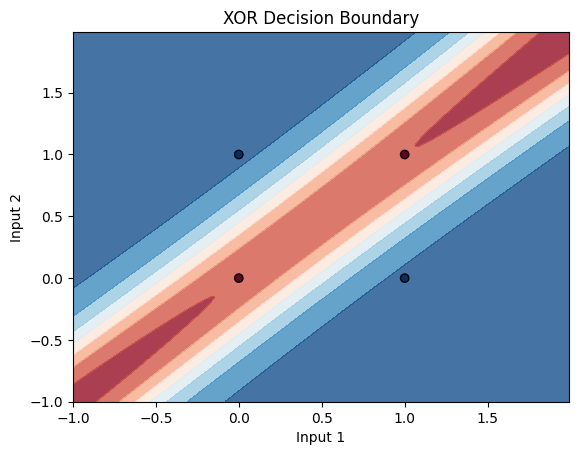

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define XOR dataset
xor_inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_targets = np.array([0, 1, 1, 0])

# Build neural network
network_shape = [2, 5, 1]
activation = Activations.TANH
output_activation = Activations.TANH
regularization = RegularizationFunctions.L2
input_ids = ['input1', 'input2']
learning_rate = 0.1
regularization_rate = 0.001
error_func = Errors.SQUARE

network = build_network(network_shape, activation, output_activation, regularization, input_ids)

# Train neural network
num_epochs = 10000

for epoch in range(num_epochs):
    for i in range(len(xor_inputs)):
        inputs = xor_inputs[i]
        target = xor_targets[i]
        forward_prop(network, inputs)
        back_prop(network, target, error_func)
        update_weights(network, learning_rate, regularization_rate)

# Plot decision boundary
def plot_decision_boundary():
    h = 0.01
    x_min, x_max = xor_inputs[:, 0].min() - 1, xor_inputs[:, 0].max() + 1
    y_min, y_max = xor_inputs[:, 1].min() - 1, xor_inputs[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = np.array([forward_prop(network, np.array([x, y])) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(xor_inputs[:, 0], xor_inputs[:, 1], c=xor_targets, cmap=plt.cm.RdBu, edgecolors='k')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.title('XOR Decision Boundary')
    plt.show()

plot_decision_boundary()


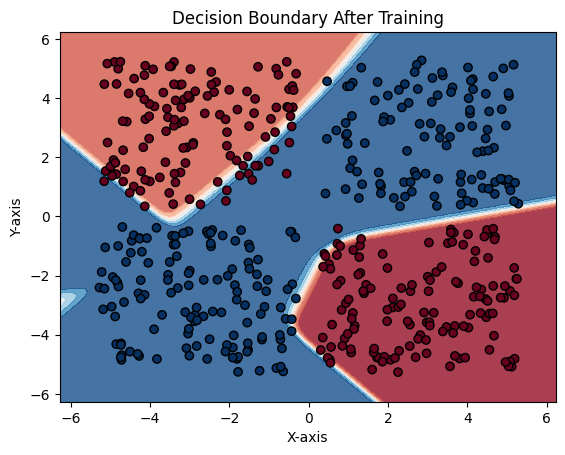

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to shuffle an array
def shuffle(array):
    counter = len(array)
    while counter > 0:
        index = np.random.randint(0, counter)
        counter -= 1
        array[counter], array[index] = array[index], array[counter]

# Define a function to classify XOR-like data
def classify_xor_data(num_samples, noise):
    def get_xor_label(point):
        return 1 if point['x'] * point['y'] >= 0 else -1

    points = []
    for i in range(num_samples):
        x = np.random.uniform(-5, 5)
        padding = 0.3
        x += padding if x > 0 else -padding
        y = np.random.uniform(-5, 5)
        y += padding if y > 0 else -padding
        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise
        label = get_xor_label({'x': x + noise_x, 'y': y + noise_y})
        points.append({'x': x, 'y': y, 'label': label})

    return points

# Define a function to train the network on the new dataset
def train_on_xor_data(network, xor_data, num_epochs, learning_rate, regularization_rate, error_func):
    inputs = np.array([[point['x'], point['y']] for point in xor_data])
    targets = np.array([point['label'] for point in xor_data])

    for epoch in range(num_epochs):
        for i in range(len(inputs)):
            input_data = inputs[i]
            target = targets[i]
            forward_prop(network, input_data)
            back_prop(network, target, error_func)
            update_weights(network, learning_rate, regularization_rate)

# Define a function to plot the decision boundary
def plot_decision_boundary_after_training(network, xor_data):
    h = 0.1
    x_min, x_max = min([point['x'] for point in xor_data]) - 1, max([point['x'] for point in xor_data]) + 1
    y_min, y_max = min([point['y'] for point in xor_data]) - 1, max([point['y'] for point in xor_data]) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = np.array([forward_prop(network, np.array([x, y])) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter([point['x'] for point in xor_data], [point['y'] for point in xor_data], c=[point['label'] for point in xor_data], cmap=plt.cm.RdBu, edgecolors='k')
    plt.title('Decision Boundary After Training')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# Example usage
xor_data = classify_xor_data(500, 0.05)

# Create and initialize the neural network
network_shape_xor = [2, 5, 1]
input_ids_xor = ['input1', 'input2']
network_xor = build_network(network_shape_xor, activation, output_activation, regularization, input_ids_xor)

# Train the network on the XOR-like dataset
num_epochs_xor = 10000
learning_rate_xor = 0.1
regularization_rate_xor = 0.001
error_func_xor = Errors.SQUARE

train_on_xor_data(network_xor, xor_data, num_epochs_xor, learning_rate_xor, regularization_rate_xor, error_func_xor)

# Plot the decision boundary after training
plot_decision_boundary_after_training(network_xor, xor_data)
